In [1]:
# Use Erdos_Spring_2025 conda env as created
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

import shap

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [2]:
fname = 'data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run 'data/utils.py'
%run 'data/features_list.py'
%run 'data/model_params.py'


In [3]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition']


In [4]:
def feature_selection(df, col, best_params=None, random_state = 1205):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    # Splitting into training (80%) and testing (20%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    
    if best_params== None:
        # Define XGBoost model
        #model = GradientBoostingClassifier(random_state=random_state)
        model = XGBClassifier(objective='reg:squarederror', random_state=random_state)
        
        param_grid = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.85, 1.0],  
            'lambda': [1,3,5]          
        }
        # Perform Grid Search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters
        best_params = grid_search.best_params_
        
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    #best_model = GradientBoostingClassifier(**best_params, random_state=random_state)
    best_model = XGBClassifier(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = best_model.predict(X_train)
    mse0 = mean_squared_error(y_train, y_pred0)
    acc0 = accuracy_score(y_train, y_pred0)
    f10 = f1_score(y_train, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_train, y_pred0, average='weighted')
    precision0 = precision_score(y_train, y_pred0, average='weighted')

    print(f"Mean Squared Error: (Test) {mse * 100:.2f}%, (Train) {mse0 * 100:.2f}%")
    print(f"Accuracy: (Test) {acc * 100:.2f}%, (Train) {acc0 * 100:.2f}%")
    print(f"Precision: (Test) {precision * 100:.2f}%, (Train) {precision0 * 100:.2f}%")
    print(f"Recall: (Test) {recall * 100:.2f}%, (Train) {recall0 * 100:.2f}%")
    print(f"F1 Score: (Test) {f1 * 100:.2f}%, (Train) {f10 * 100:.2f}%")
    print("-" * 30)
    
    # Feature Importance
    feature_names = X.columns.tolist()
    importance = best_model.feature_importances_
    f_pairs = list(zip(importance, feature_names))
    f_pairs.sort()
    importance_sort, feature_names_sort = zip(*f_pairs)
    
    # Prepare DataFrame for seaborn
    importance_df = pd.DataFrame({
        "Feature": feature_names_sort,
        "Importance": importance_sort,
        "Category": [feature_to_category.get(f, "Other") for f in feature_names_sort]
    })
    
    # # Compute Pearson correlation with the target for each feature
    # correlations = {
    #     feature: np.corrcoef(df[feature], df[target_col])[0, 1]
    #     if df[feature].dtype in [np.float64, np.int64, np.int32] else np.nan
    #     for feature in importance_df["Feature"]
    # }##
    
    #------
    # Train logistic regression for coefficient inspection
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    logreg = LogisticRegression(max_iter=1000, random_state=random_state)
    logreg.fit(X_scaled, y_train)

    # Map coefficients to feature names
    logreg_coeffs = dict(zip(X.columns, logreg.coef_[0]))  # assumes binary classification
    #------
    
    importance_df = importance_df[::-1]
    importance_df = importance_df.head(15)
    
    
    # # Round and attach correlation values to labels
    # importance_df["Corr"] = importance_df["Feature"].map(lambda f: correlations.get(f, np.nan))
    
    # importance_df["LabelWithCorr"] = importance_df.apply(
    #     lambda row: f"{row['Feature'].replace('_', ' ').title()} ({format_sci_notation(row['Corr'])})"
    #     if not np.isnan(row['Corr']) else row['Feature'].replace('_', ' ').title(),
    #     axis=1
    # )
    
    #-----
    # Round and attach logistic regression coefficients to labels
    importance_df["LogRegCoef"] = importance_df["Feature"].map(lambda f: logreg_coeffs.get(f, np.nan))

    importance_df["LabelWithCoef"] = importance_df.apply(
        lambda row: f"{row['Feature'].replace('_', ' ').title()} ({format_sci_notation(row['LogRegCoef'])})"
        if not np.isnan(row['LogRegCoef']) else row['Feature'].replace('_', ' ').title(),
        axis=1
    )
    #-----
    
    # Map colors based on categories
    importance_df["Color"] = importance_df["Category"].map(category_colors).fillna("#7f7f7f")

    # Plot with seaborn
    plt.figure(figsize=(12, 6))

    # sns.barplot(
    #     data=importance_df,
    #     y="LabelWithCorr",
    #     x="Importance",
    #     palette=importance_df.set_index("LabelWithCorr")["Color"].to_dict(),
    #     order=importance_df["LabelWithCorr"]
    # )
    
    #-----
    sns.barplot(
        data=importance_df,
        y="LabelWithCoef",
        x="Importance",
        palette=importance_df.set_index("LabelWithCoef")["Color"].to_dict(),
        order=importance_df["LabelWithCoef"]
    )
    #-----

    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.xscale("log")
 
    legend_patches = [
        Patch(color=color, label=cat.replace("_", " ").title()) for cat, color in category_colors.items()
    ]
    plt.legend(handles=legend_patches, title="Feature Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

    #plt.tight_layout()
    plt.show()
    plt.clf()
    
    # SHAP values for feature selection
    # explainer = shap.Explainer(best_model)
    # shap_values = explainer(X_train)
    # shap.summary_plot(shap_values, X_train, feature_names=feature_names)
    
    # results = partial_dependence(best_model, X_train, [0])
    # print(results['average'])
    # plt.figure(figsize=(12, 12))
    # PartialDependenceDisplay.from_estimator(best_model, X_train, features=feature_names, kind='individual')

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.90%, (Train) 46.97%
Accuracy: (Test) 53.10%, (Train) 53.03%
Precision: (Test) 28.20%, (Train) 28.12%
Recall: (Test) 53.10%, (Train) 53.03%
F1 Score: (Test) 36.83%, (Train) 36.75%
------------------------------


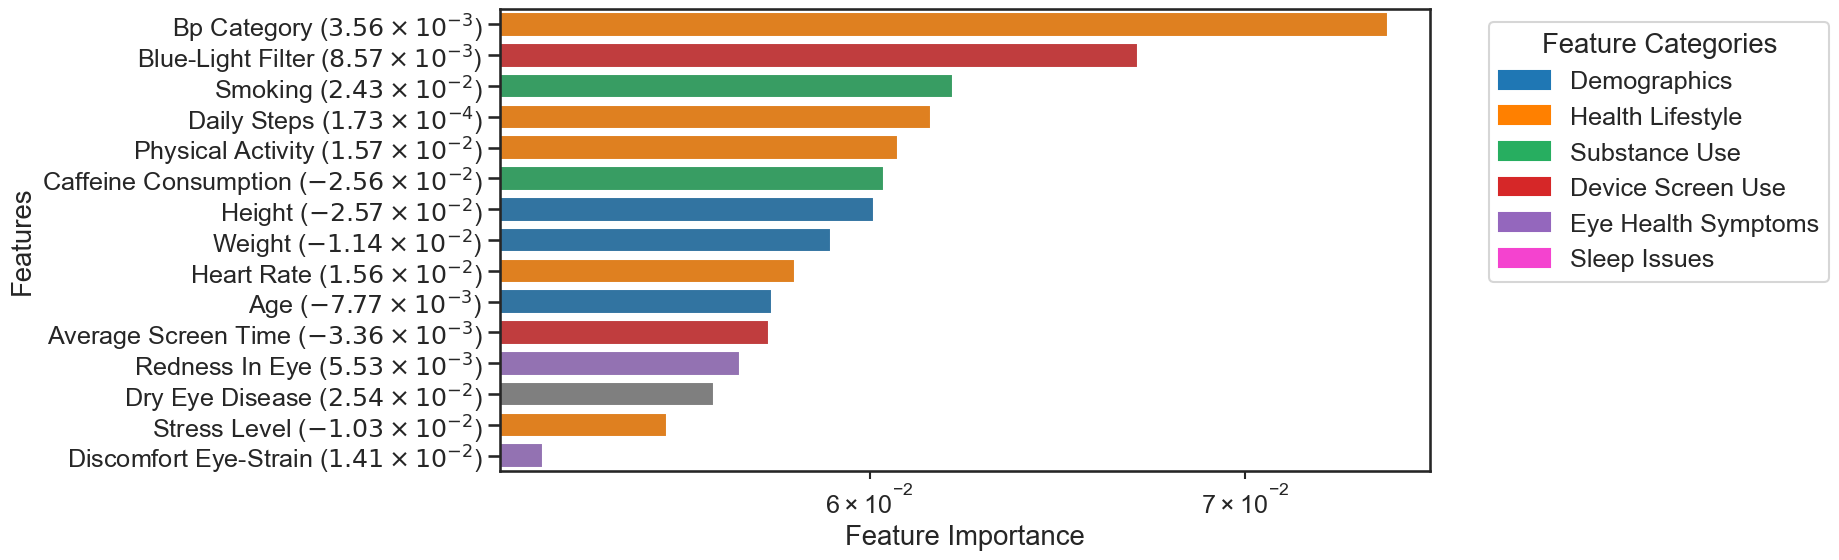

<Figure size 640x480 with 0 Axes>

In [5]:
best_p = {'lambda': 3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
feature_selection(df, 'insomnia', best_params=None)

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.70%, (Train) 46.35%
Accuracy: (Test) 53.30%, (Train) 53.65%
Precision: (Test) 46.01%, (Train) 70.91%
Recall: (Test) 53.30%, (Train) 53.65%
F1 Score: (Test) 37.61%, (Train) 38.57%
------------------------------


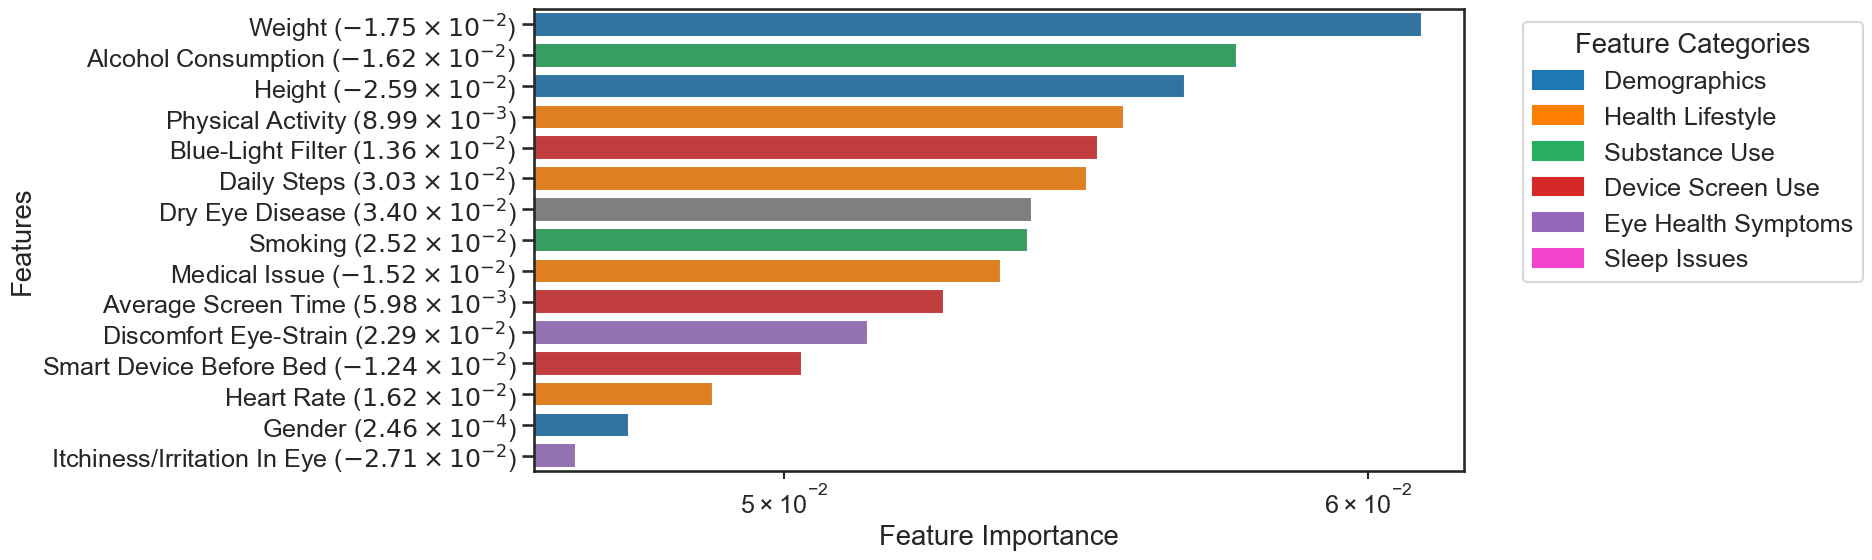

<Figure size 640x480 with 0 Axes>

In [6]:
best_p = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
df1 = df[df['age']<35]
df1 = df1.drop(columns='age')
feature_selection(df1, 'insomnia', best_params=None)

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.74%, (Train) 46.49%
Accuracy: (Test) 53.26%, (Train) 53.51%
Precision: (Test) 28.42%, (Train) 72.58%
Recall: (Test) 53.26%, (Train) 53.51%
F1 Score: (Test) 37.06%, (Train) 37.61%
------------------------------


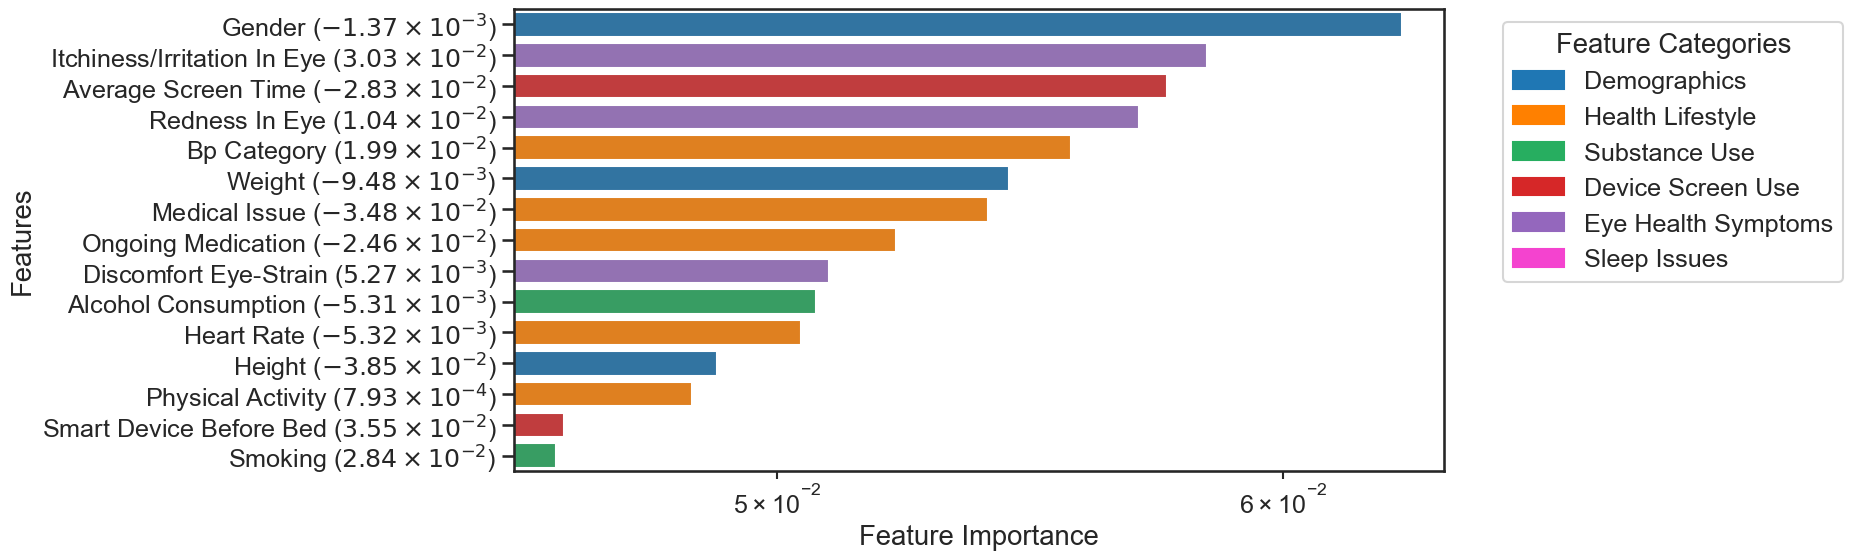

<Figure size 640x480 with 0 Axes>

In [7]:
best_p = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
df1 = df[df['age']>=35]
df1 = df1.drop(columns='age')
feature_selection(df1, 'insomnia', best_params=None)


Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Mean Squared Error: (Test) 48.48%, (Train) 45.27%
Accuracy: (Test) 51.52%, (Train) 54.73%
Precision: (Test) 48.47%, (Train) 58.87%
Recall: (Test) 51.52%, (Train) 54.73%
F1 Score: (Test) 40.00%, (Train) 43.17%
------------------------------


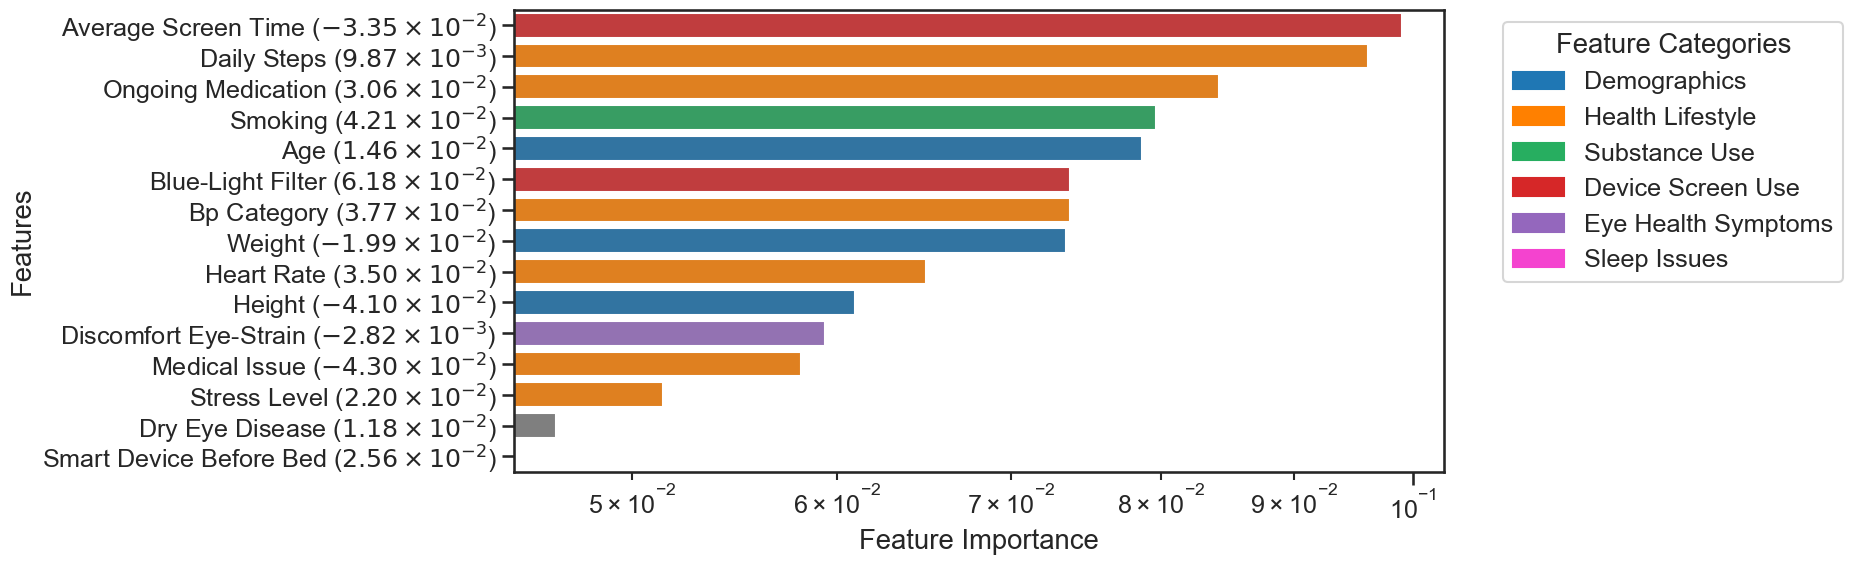

<Figure size 640x480 with 0 Axes>

In [8]:
best_p = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
df1 = df[df['physical_activity']<90]
df1 = df1.drop(columns='physical_activity')
feature_selection(df1, 'insomnia', best_params=None)

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.81%, (Train) 46.91%
Accuracy: (Test) 53.19%, (Train) 53.09%
Precision: (Test) 28.29%, (Train) 28.18%
Recall: (Test) 53.19%, (Train) 53.09%
F1 Score: (Test) 36.93%, (Train) 36.82%
------------------------------


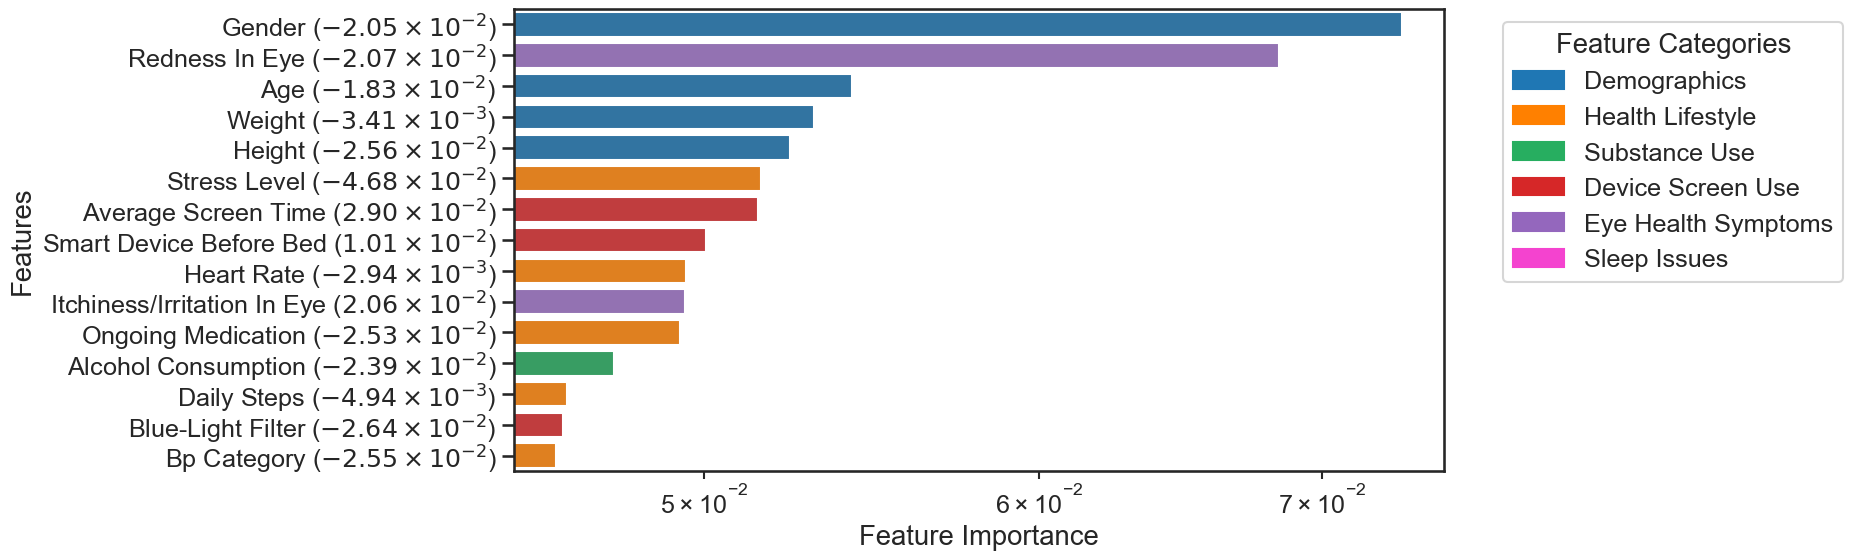

<Figure size 640x480 with 0 Axes>

In [9]:
best_p = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
df1 = df[df['physical_activity']>=90]
df1 = df1.drop(columns='physical_activity')
feature_selection(df1, 'insomnia', best_params=None)

Best Parameters: {'lambda': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 48.06%, (Train) 46.62%
Accuracy: (Test) 51.94%, (Train) 53.38%
Precision: (Test) 26.98%, (Train) 28.49%
Recall: (Test) 51.94%, (Train) 53.38%
F1 Score: (Test) 35.52%, (Train) 37.15%
------------------------------


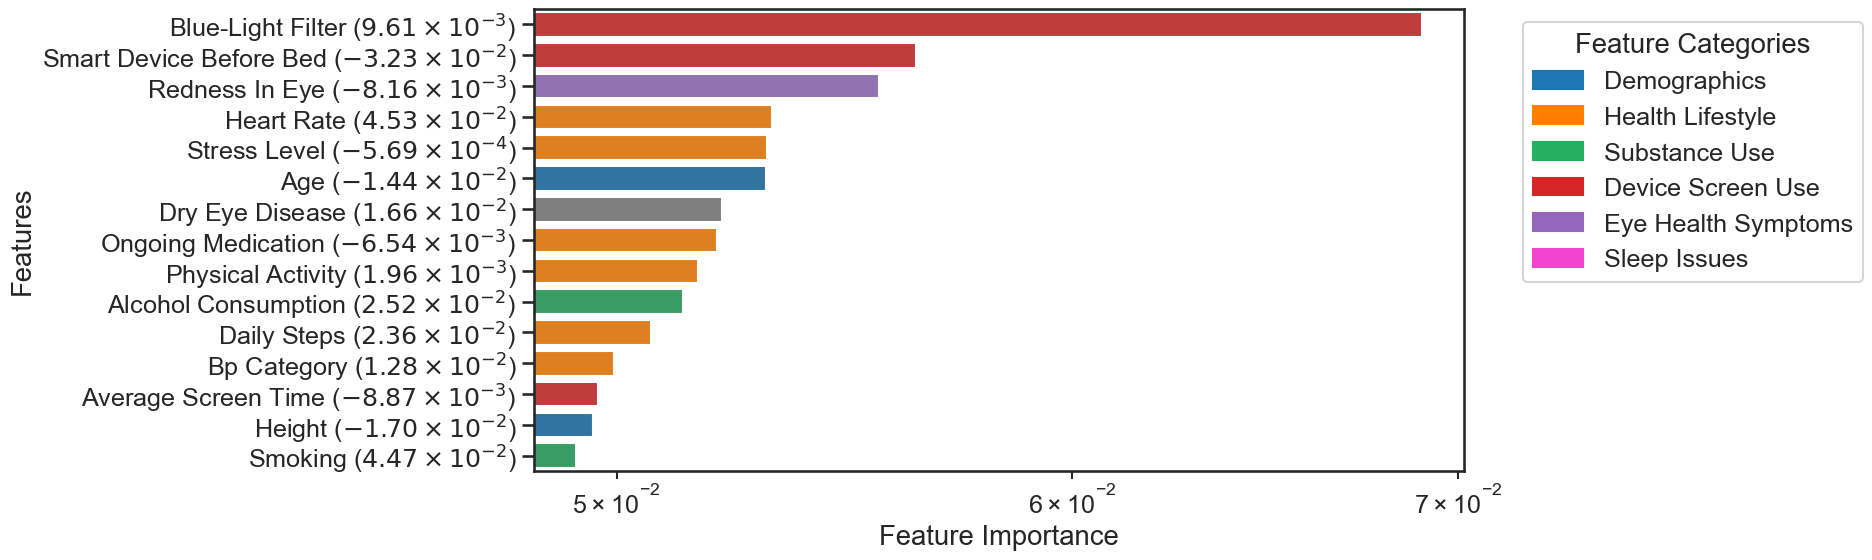

<Figure size 640x480 with 0 Axes>

In [15]:
best_p = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
df1 = df[df['gender']==1]
df1 = df1.drop(columns='gender')
feature_selection(df1, 'insomnia', best_params=None)

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean Squared Error: (Test) 47.27%, (Train) 46.55%
Accuracy: (Test) 52.73%, (Train) 53.45%
Precision: (Test) 51.45%, (Train) 62.29%
Recall: (Test) 52.73%, (Train) 53.45%
F1 Score: (Test) 37.11%, (Train) 38.07%
------------------------------


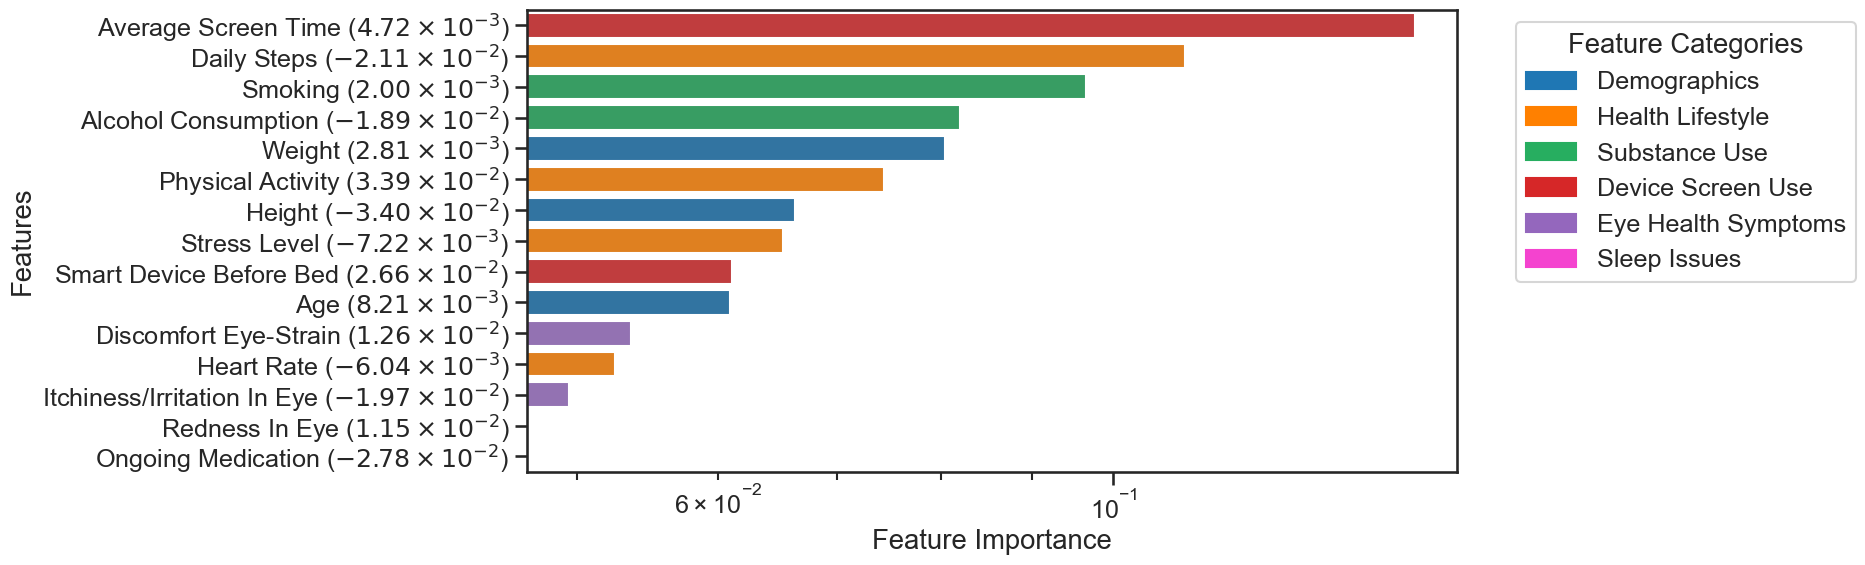

<Figure size 640x480 with 0 Axes>

In [16]:
best_p = {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
df1 = df[df['gender']==0]
df1 = df1.drop(columns='gender')
feature_selection(df1, 'insomnia', best_params=None)

In [12]:
def feature_category(df, col, best_params=None, random_state=1205):
    target_col = col
    y = df[target_col]
    X = df.drop(columns=target_col)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    if best_params== None:
        # Define XGBoost model
        #model = GradientBoostingClassifier(random_state=random_state)
        model = XGBClassifier(objective='reg:squarederror', random_state=random_state)
        
        param_grid = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.85, 1.0],  
            'lambda': [1,3,5]          
        }
        # Perform Grid Search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters
        best_params = grid_search.best_params_
        
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    #best_model = GradientBoostingClassifier(**best_params, random_state=random_state)
    best_model = XGBClassifier(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)

    # Evaluate
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_test) * 100:.2f}%, {mean_squared_error(y_train, y_pred_train) * 100:.2f}%")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test) * 100:.2f}%, {accuracy_score(y_train, y_pred_train) * 100:.2f}%")
    print(f"Precision: {precision_score(y_test, y_pred_test, average='weighted') * 100:.2f}%, {precision_score(y_train, y_pred_train, average='weighted') * 100:.2f}%")
    print(f"Recall: {recall_score(y_test, y_pred_test, average='weighted') * 100:.2f}%, {recall_score(y_train, y_pred_train, average='weighted') * 100:.2f}%")
    print(f"F1 Score: {f1_score(y_test, y_pred_test, average='weighted') * 100:.2f}%, {f1_score(y_train, y_pred_train, average='weighted') * 100:.2f}%")
    print("-" * 30)

    # Feature Importance
    importance = best_model.feature_importances_
    feature_names = X.columns.tolist()
    f_pairs = sorted(zip(importance, feature_names))
    importance_sort, feature_names_sort = zip(*f_pairs)

    importance_df = pd.DataFrame({
        "Feature": feature_names_sort,
        "Importance": importance_sort
    })

    # Compute correlations
    correlations = {
        feature: np.corrcoef(df[feature], df[target_col])[0, 1]
        if df[feature].dtype in [np.float64, np.int64, np.int32] else np.nan
        for feature in importance_df["Feature"]
    }

    def format_sci_notation(val):
        if np.isnan(val):
            return ""
        exponent = int(np.floor(np.log10(abs(val)))) if val != 0 else 0
        base = val / 10**exponent if val != 0 else 0
        return r"${:.2f} \times 10^{{{}}}$".format(base, exponent)

    importance_df["Corr"] = importance_df["Feature"].map(lambda f: correlations.get(f, np.nan))
    importance_df["LabelWithCorr"] = importance_df.apply(
        lambda row: f"{row['Feature'].replace('_', ' ').title()} ({format_sci_notation(row['Corr'])})"
        if not np.isnan(row['Corr']) else row['Feature'].replace('_', ' ').title(),
        axis=1
    )

    # Add category and color
    importance_df["Category"] = importance_df["Feature"].map(lambda f: feature_to_category.get(f, "Other"))
    importance_df["Color"] = importance_df["Category"].map(category_colors).fillna("#7f7f7f")

    # Sort and select top 15
    importance_df = importance_df.sort_values("Importance", ascending=False).head(15)

    # Plot
    plt.figure(figsize=(8, 3))
    sns.barplot(
        data=importance_df,
        y="LabelWithCorr",
        x="Importance",
        palette=importance_df.set_index("LabelWithCorr")["Color"].to_dict(),
        order=importance_df["LabelWithCorr"]
    )

    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.xscale("linear")
    plt.tight_layout()
    plt.show()
    plt.clf()

Best Parameters: {'lambda': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
Mean Squared Error: 46.90%, 46.97%
Accuracy: 53.10%, 53.03%
Precision: 28.20%, 28.12%
Recall: 53.10%, 53.03%
F1 Score: 36.83%, 36.75%
------------------------------


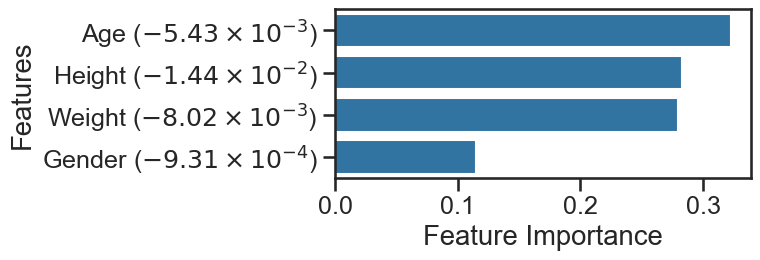

Best Parameters: {'lambda': 5, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error: 47.05%, 42.62%
Accuracy: 52.95%, 57.38%
Precision: 51.14%, 67.38%
Recall: 52.95%, 57.38%
F1 Score: 41.40%, 47.47%
------------------------------


<Figure size 640x480 with 0 Axes>

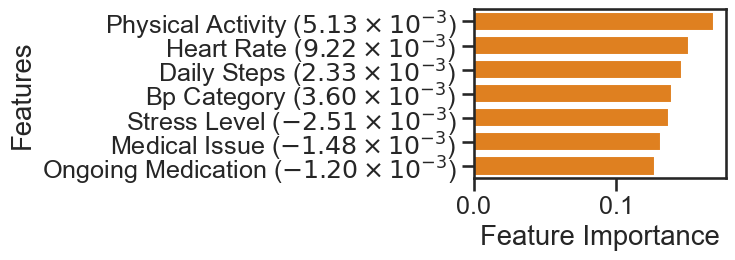

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 46.90%, 46.97%
Accuracy: 53.10%, 53.03%
Precision: 28.20%, 28.12%
Recall: 53.10%, 53.03%
F1 Score: 36.83%, 36.75%
------------------------------


<Figure size 640x480 with 0 Axes>

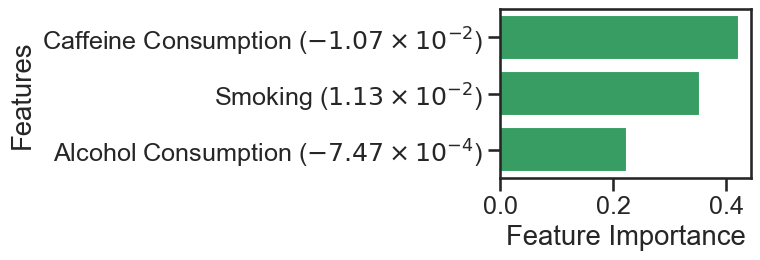

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 46.90%, 46.97%
Accuracy: 53.10%, 53.03%
Precision: 28.20%, 28.12%
Recall: 53.10%, 53.03%
F1 Score: 36.83%, 36.75%
------------------------------


<Figure size 640x480 with 0 Axes>

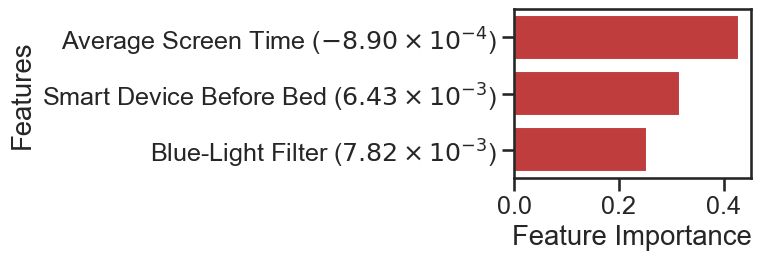

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: 46.90%, 46.97%
Accuracy: 53.10%, 53.03%
Precision: 28.20%, 28.12%
Recall: 53.10%, 53.03%
F1 Score: 36.83%, 36.75%
------------------------------


<Figure size 640x480 with 0 Axes>

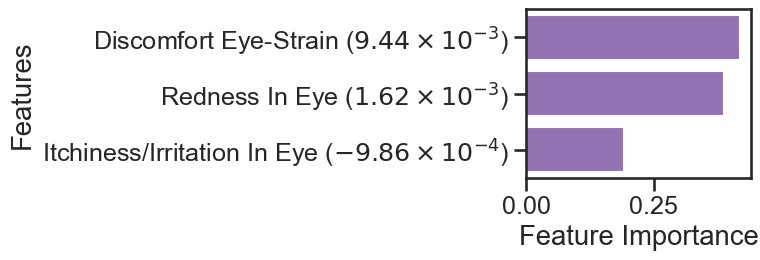

<Figure size 640x480 with 0 Axes>

In [14]:
for cat in category_map:
    ll = category_map[cat].copy()
    ll.extend(list(["insomnia"]))
    df1 = df[ll]
    best_p = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
    feature_category(df1, 'insomnia', best_params=None)